In [18]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image


# parser = argparse.ArgumentParser(description='VAE MNIST Example')
# parser.add_argument('--batch-size', type=int, default=128, metavar='N',
#                     help='input batch size for training (default: 128)')
# parser.add_argument('--epochs', type=int, default=10, metavar='N',
#                     help='number of epochs to train (default: 10)')
# parser.add_argument('--no-cuda', action='store_true', default=False,
#                     help='disables CUDA training')
# parser.add_argument('--seed', type=int, default=1, metavar='S',
#                     help='random seed (default: 1)')
# parser.add_argument('--log-interval', type=int, default=10, metavar='N',
#                     help='how many batches to wait before logging training status')
# args = parser.parse_args()
# args.cuda = not args.no_cuda and torch.cuda.is_available()

torch.manual_seed(7)
batch_size=64

# kwargs = {'num_workers': 1, 'pin_memory': True} if args.cuda else {}


train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True,)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True)


class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


model = VAE()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD


def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],recon_batch.view(batch_size, 1, 28, 28)[:n]])
                save_image(comparison.cpu(), './reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

if __name__ == "__main__":
    for epoch in range(1,300):
        train(epoch)
        test(epoch)
        with torch.no_grad():
            sample = torch.randn(64, 20)
            sample = model.decode(sample).cpu()
            save_image(sample.view(64, 1, 28, 28),
                       './sample_' + str(epoch) + '.png')

Train Epoch: 1 [0/60000 (0%)]	Loss: 550.007996
Train Epoch: 1 [6400/60000 (11%)]	Loss: 182.565079
Train Epoch: 1 [12800/60000 (21%)]	Loss: 158.018173
Train Epoch: 1 [19200/60000 (32%)]	Loss: 152.305542
Train Epoch: 1 [25600/60000 (43%)]	Loss: 128.662598
Train Epoch: 1 [32000/60000 (53%)]	Loss: 129.949722
Train Epoch: 1 [38400/60000 (64%)]	Loss: 131.803040
Train Epoch: 1 [44800/60000 (75%)]	Loss: 128.187347
Train Epoch: 1 [51200/60000 (85%)]	Loss: 122.973801
Train Epoch: 1 [57600/60000 (96%)]	Loss: 121.044891
====> Epoch: 1 Average loss: 146.7496
====> Test set loss: 119.1544
Train Epoch: 2 [0/60000 (0%)]	Loss: 122.132347
Train Epoch: 2 [6400/60000 (11%)]	Loss: 122.975044
Train Epoch: 2 [12800/60000 (21%)]	Loss: 112.275848
Train Epoch: 2 [19200/60000 (32%)]	Loss: 117.202362
Train Epoch: 2 [25600/60000 (43%)]	Loss: 121.091209
Train Epoch: 2 [32000/60000 (53%)]	Loss: 122.420563
Train Epoch: 2 [38400/60000 (64%)]	Loss: 108.191025
Train Epoch: 2 [44800/60000 (75%)]	Loss: 118.630280
Train Ep

KeyboardInterrupt: ignored

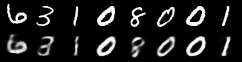

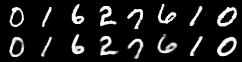

In [20]:
import cv2
from google.colab.patches import cv2_imshow

# ! wget https://raw.githubusercontent.com/karaposu/Brain_typing/master/a.png


image = cv2.imread('reconstruction_1.png')
image2 = cv2.imread('reconstruction_19.png')

cv2_imshow( image)
cv2_imshow( image2)